<a href="https://colab.research.google.com/github/flyaflya/persuasive/blob/main/demoNotebooks/carsFixedWalkthroughPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install matplotlib numpyro daft --upgrade  ##restart runtime

## Get the Data (Again for Part 2)

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/flyaflya/persuasive/main/carsFixed.csv"
carsDF = pd.read_csv(url)
carsDF

,observation,shopID,boss,carsFixed
0,1,1,0,8
1,2,2,0,22
2,3,3,0,32
3,4,4,1,64
4,5,5,0,53
...,...,...,...,...
245,246,1,1,18
246,247,2,0,22
247,248,3,0,31
248,249,4,0,26


## Last time, we had an issue with python-based indexing
## offsetting the shop ID's by 1
## let's not get confused by using numeric indexes
## so, we fix the shop names using pd.factorize and indexes

In [17]:
carsDF["shopName"] = "Shop" + carsDF.shopID.astype("str")
carsDF["pythonShopID"] = pd.factorize(carsDF.shopName)[0]
carsDF

,observation,shopID,boss,carsFixed,shopName,pythonShopID
0,1,1,0,8,Shop1,0
1,2,2,0,22,Shop2,1
2,3,3,0,32,Shop3,2
3,4,4,1,64,Shop4,3
4,5,5,0,53,Shop5,4
...,...,...,...,...,...,...
245,246,1,1,18,Shop1,0
246,247,2,0,22,Shop2,1
247,248,3,0,31,Shop3,2
248,249,4,0,26,Shop4,3


Great!! that is easier to undertand.  let's keep iterating our complexity

In [43]:
# load needed pacakges - note, will use jax.numpy for functions
# instead of using regular numpy.  numpyro likes jax versions of 
# numpy functions - otherwise, get weird errors
import xarray as xr
import numpy as np   
import jax.numpy as jnp   ## note this line
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
import arviz as az

## Let's now do model the boss effect and treat each shop independently using this model

![](https://raw.githubusercontent.com/flyaflya/persuasive/main/images/bossEffectDAG.png)

In [42]:
## map above DAG to numpyro code
def fixedCarsModelWithBoss(carsFixed, shopID, bossPresent):
    ## NOTE LAMBDA IS RESERVED WORD IN PYTHON... MUST USE MODIFIED NAME
    with numpyro.plate("j", len(np.unique(shopID))):
        beta_shop = numpyro.sample('Boss Effect - Shop Level', dist.Normal(loc = 0, scale = 2))
        alpha_shop = numpyro.sample('Intercept - Shop Level', dist.Normal(loc = 3, scale = 2))

    with numpyro.plate('observation', len(carsFixed)):
        # below: need to use numpy.jax version of exponential function to avoid error
        # we are just using a plain old formula for determinsitic node
        lambdaParam = jnp.exp(alpha_shop[shopID] + beta_shop[shopID] * bossPresent)
        k = numpyro.sample('obs. cars fixed', dist.Poisson(rate = lambdaParam), obs = carsFixed)

## get posterior in standard way
mcmc = MCMC(NUTS(fixedCarsModelWithBoss), num_warmup=1000, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(rng_key, carsFixed=carsDF.carsFixed.values, shopID = carsDF.pythonShopID.values, bossPresent = carsDF.boss.values) ## get representative sample of posterior
drawsDS = az.from_numpyro(mcmc,
                coords={"shopName": pd.factorize(carsDF.shopName)[1]},
                dims={"Intercept - Shop Level": ["shopName"],
                      "Boss Effect - Shop Level": ["shopName"]}).posterior ## get posterior samples into xarray
drawsDS

sample: 100%|██████████| 5000/5000 [00:11<00:00, 420.54it/s, 7 steps of size 5.67e-01. acc. prob=0.88]


<xarray.Dataset>
Dimensions:                   (chain: 1, draw: 4000, shopName: 5)
Coordinates:
  * chain                     (chain) int64 0
  * draw                      (draw) int64 0 1 2 3 4 ... 3996 3997 3998 3999
  * shopName                  (shopName) object 'Shop1' 'Shop2' ... 'Shop5'
Data variables:
    Boss Effect - Shop Level  (chain, draw, shopName) float32 0.4323 ... 0.08811
    Intercept - Shop Level    (chain, draw, shopName) float32 2.374 ... 3.869
Attributes:
    created_at:                 2022-12-01T15:57:19.704441
    arviz_version:              0.12.1
    inference_library:          numpyro
    inference_library_version:  0.10.1

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

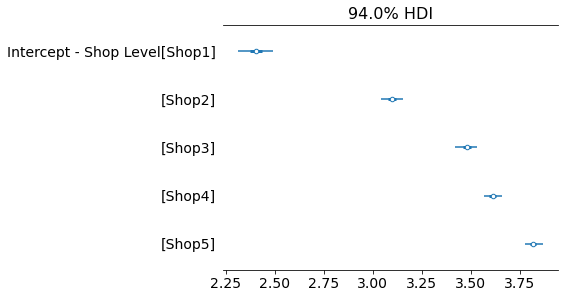

In [37]:
## show the expected linear predictor for the intercept
az.plot_forest(drawsDS, var_names = "Intercept - Shop Level")

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

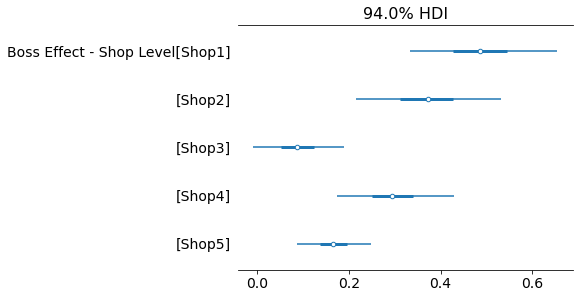

In [38]:
## show the expected change to linear predictor when boss is around
az.plot_forest(drawsDS, var_names = "Boss Effect - Shop Level")

In [54]:
## using shop3 as an example, to get from linear predictor to expected cars fixed
## use the exponential function as suggested by the DAG
drawsDS = (
    drawsDS
    .assign(lambdaNoBoss = np.exp(drawsDS["Intercept - Shop Level"]))
    .assign(lambdaWithBoss = np.exp(drawsDS["Intercept - Shop Level"] + drawsDS["Boss Effect - Shop Level"]))
)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

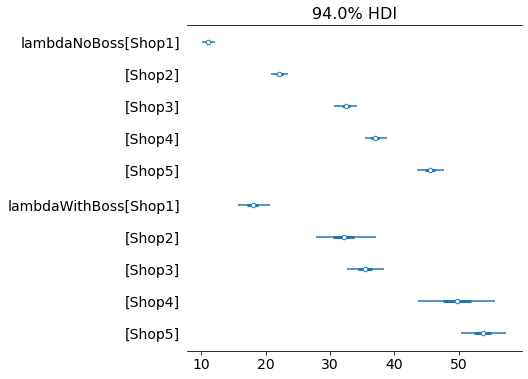

In [50]:
## and now we can plot on a more meaningful scale, i.e. exp Cars Fixed
## show the expected change to linear predictor when boss is around
az.plot_forest(drawsDS, var_names = ["lambdaNoBoss","lambdaWithBoss"])

## THOUGHT QUESTION:  Explain why lambdaNoBoss[Shop 1] seems narrower than  lambaNoBoss[Shop 3], yet lambaWithBoss[Shop 3] seems narrower than lambaWithBoss[Shop 1]?

## Extracting HDI (credible interval) DATA for Plotting Using MATPLOTLIB

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

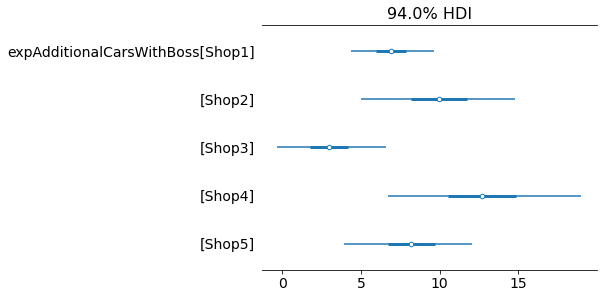

In [57]:
drawsDS = (
    drawsDS
    ## now calculate difference between the lambdas to get 4,000 draws of
    ## expected additional cars fixed
    .assign(expAdditionalCarsWithBoss = drawsDS.lambdaWithBoss - drawsDS.lambdaNoBoss)
)
az.plot_forest(drawsDS, var_names = "expAdditionalCarsWithBoss")  
## this is automated plot, good for us, horrible for Patrick

In [66]:
credibleIntervalDataset = az.hdi(drawsDS.expAdditionalCarsWithBoss, hdi_prob=.90)
credibleIntervalDataset

<xarray.Dataset>
Dimensions:                    (shopName: 5, hdi: 2)
Coordinates:
  * shopName                   (shopName) object 'Shop1' 'Shop2' ... 'Shop5'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    expAdditionalCarsWithBoss  (shopName, hdi) float64 4.686 9.293 ... 11.74

## Now, use a pandas dataframe (get rid of multi-index) to facilitate more typical matplotlib plotting workflows

In [67]:
plotDF = (
    credibleIntervalDataset
    .to_dataframe()
    .reset_index()
)
plotDF

,shopName,hdi,expAdditionalCarsWithBoss
0,Shop1,lower,4.686316
1,Shop1,higher,9.293337
2,Shop2,lower,5.734341
3,Shop2,higher,14.225897
4,Shop3,lower,0.039005
5,Shop3,higher,5.989082
6,Shop4,lower,7.250271
7,Shop4,higher,17.958706
8,Shop5,lower,4.585518
9,Shop5,higher,11.744892


In [70]:
## use for loop to plot interval bars

## order by hdi max
shopNames = pd.factorize(carsDF.shopName)[1]

## demo of simple for loop that will be put into matplotlib workflow
for shopName in shopNames:
    print(shopName)

Shop1
Shop2
Shop3
Shop4
Shop5


In [79]:
## get better order for plotting
shopNamesOrder = (
    plotDF
    .query('hdi == "higher"')
    .sort_values("expAdditionalCarsWithBoss")
    .get("shopName")
    .values
)
shopNamesOrder

array(['Shop3', 'Shop1', 'Shop5', 'Shop2', 'Shop4'], dtype=object)

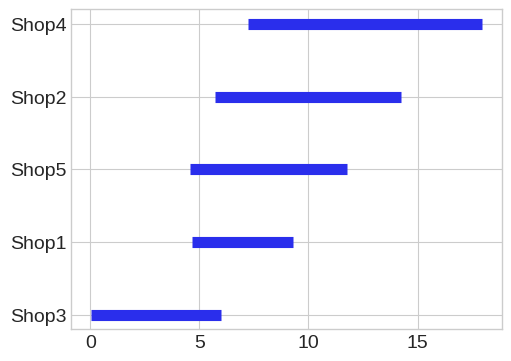

In [97]:
import matplotlib.pyplot as plt
plt.style.use("arviz-whitegrid")

fig, ax = plt.subplots(figsize = [5,3.5], layout = "constrained")

## now loop over shop names and make a 90% cred interval bar
for shopName in shopNamesOrder:
    lowerBound = plotDF[(plotDF.shopName == shopName) & (plotDF.hdi == "lower")].expAdditionalCarsWithBoss.values
    upperBound = plotDF[(plotDF.shopName == shopName) & (plotDF.hdi == "higher")].expAdditionalCarsWithBoss.values
    ax.hlines(y = shopName, xmin = lowerBound, xmax = upperBound, linewidths = 8)

In [92]:
plotDF[(plotDF.shopName == "Shop1") & (plotDF.hdi == "lower")].expAdditionalCarsWithBoss.values

array([4.68631649])

## NOW DO THE FINAL MODEL WHERE EACH SHOP IS NOT INDEPENDENT, THEY HAVE COMMON PARENT NODES DICTATING ALPHA AND BETA - REVIEW THIS CODE ON YOUR OWN
![](https://raw.githubusercontent.com/flyaflya/persuasive/main/images/midasDAG.png)

In [102]:
## map above DAG to numpyro code
def fixedCarsModelWithBossShareInfo(carsFixed, shopID, bossPresent):
    alpha = numpyro.sample('Intercept - Midas Level', dist.Normal(loc = 3, scale = 2))
    sigma_alpha = numpyro.sample('StdDev - Midas Level', dist.Uniform(low = 0, high = 2))
    beta = numpyro.sample('Exp Boss Effect - Midas Level', dist.Normal(loc = 0, scale = 1))
    sigma_beta = numpyro.sample('Std Dev Boss Effect - Midas Level', dist.Uniform(low = 0, high = 2))


    ## NOTE LAMBDA IS RESERVED WORD IN PYTHON... MUST USE MODIFIED NAME
    with numpyro.plate("j", len(np.unique(shopID))):
        alpha_shop = numpyro.sample('Intercept - Shop Level', dist.Normal(loc = alpha, scale = sigma_alpha))
        beta_shop = numpyro.sample('Boss Effect - Shop Level', dist.Normal(loc = beta, scale = sigma_beta))

    with numpyro.plate('observation', len(carsFixed)):
        # below: need to use numpy.jax version of exponential function to avoid error
        # we are just using a plain old formula for determinsitic node
        lambdaParam = jnp.exp(alpha_shop[shopID] + beta_shop[shopID] * bossPresent)
        k = numpyro.sample('obs. cars fixed', dist.Poisson(rate = lambdaParam), obs = carsFixed)

## get posterior in standard way
mcmc = MCMC(NUTS(fixedCarsModelWithBossShareInfo), num_warmup=1000, num_samples=4000) 
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(rng_key, carsFixed=carsDF.carsFixed.values, shopID = carsDF.pythonShopID.values, bossPresent = carsDF.boss.values) ## get representative sample of posterior
drawsDS = az.from_numpyro(mcmc,
                coords={"shopName": pd.factorize(carsDF.shopName)[1]},
                dims={"Intercept - Shop Level": ["shopName"],
                      "Boss Effect - Shop Level": ["shopName"]}).posterior ## get posterior samples into xarray
drawsDS

sample: 100%|██████████| 5000/5000 [00:12<00:00, 393.24it/s, 15 steps of size 3.78e-01. acc. prob=0.87]


<xarray.Dataset>
Dimensions:                            (chain: 1, draw: 4000, shopName: 5)
Coordinates:
  * chain                              (chain) int64 0
  * draw                               (draw) int64 0 1 2 3 ... 3997 3998 3999
  * shopName                           (shopName) object 'Shop1' ... 'Shop5'
Data variables:
    Boss Effect - Shop Level           (chain, draw, shopName) float32 0.3153...
    Exp Boss Effect - Midas Level      (chain, draw) float32 0.1969 ... 0.2418
    Intercept - Midas Level            (chain, draw) float32 3.468 ... 3.342
    Intercept - Shop Level             (chain, draw, shopName) float32 2.494 ...
    Std Dev Boss Effect - Midas Level  (chain, draw) float32 0.1135 ... 0.1262
    StdDev - Midas Level               (chain, draw) float32 0.3857 ... 1.91
Attributes:
    created_at:                 2022-12-01T17:37:34.857507
    arviz_version:              0.12.1
    inference_library:          numpyro
    inference_library_version:  0.10.1

In [103]:
# get expAdditionalCarsWithBoss
drawsDS = (
    drawsDS
    .assign(lambdaNoBoss = np.exp(drawsDS["Intercept - Shop Level"]))
    .assign(lambdaWithBoss = np.exp(drawsDS["Intercept - Shop Level"] + drawsDS["Boss Effect - Shop Level"]))
    .assign(expAdditionalCarsWithBoss = lambda DS: DS.lambdaWithBoss - DS.lambdaNoBoss)
)

In [104]:
# get dataframe with credible intervals
credibleIntervalDataset = az.hdi(drawsDS.expAdditionalCarsWithBoss, hdi_prob=.90)
plotDF = (
    credibleIntervalDataset
    .to_dataframe()
    .reset_index()
)

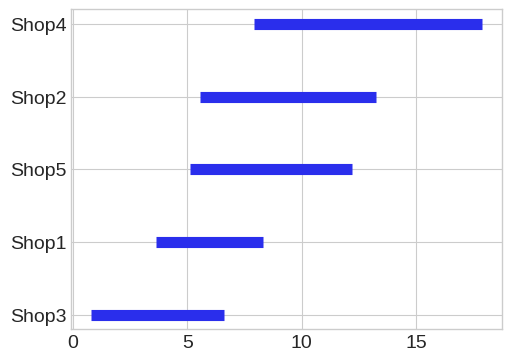

In [105]:
# plot new data with shared info
import matplotlib.pyplot as plt
plt.style.use("arviz-whitegrid")

fig, ax = plt.subplots(figsize = [5,3.5], layout = "constrained")

## now loop over shop names and make a 90% cred interval bar
for shopName in shopNamesOrder:
    lowerBound = plotDF[(plotDF.shopName == shopName) & (plotDF.hdi == "lower")].expAdditionalCarsWithBoss.values
    upperBound = plotDF[(plotDF.shopName == shopName) & (plotDF.hdi == "higher")].expAdditionalCarsWithBoss.values
    ax.hlines(y = shopName, xmin = lowerBound, xmax = upperBound, linewidths = 8)

## similar to previous, but not identical. e.g shop 5 is now clearly above 5 extra cars when boss is present

## Use this last model for your second plot.  This plot has the key information to convey to Patrick, but its ugly :-(   Interesting results.  The busiest store, Shop5, you would think might end up with the biggest boss effect.  However, that is not the case.  Shop4 is most likely the larger effect.  Use an indicator function to quantify your confidence that the boss effect is bigger at Shop4 than at Shop5:

In [109]:
(
    drawsDS
    .assign(indicatorFlag = lambda DS: 
            DS.expAdditionalCarsWithBoss.sel(shopName = 'Shop4') > 
            DS.expAdditionalCarsWithBoss.sel(shopName = 'Shop5'))
    .indicatorFlag # isolate variable of interest
    .mean()
)

<xarray.DataArray 'indicatorFlag' ()>
array(0.84875)

so, about 85% confident that the boss effect at Shop 5 is bigger than at Shop4. (more data would lead to greater confidence)